In [1]:
import os
import json
from pprint import pprint
from copy import deepcopy

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm


In [ ]:
!pip install Levenshtein

In [2]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import string
import pandas as pd
import numpy as np
import nltk
import random
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
from nltk.metrics.distance import edit_distance
from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans
import Levenshtein
import plotly.express as px
from sklearn.manifold import TSNE
import re

In [3]:
def format_name(author):
    middle_name = " ".join(author['middle'])
    
    if author['middle']:
        return " ".join([author['first'], middle_name, author['last']])
    else:
        return " ".join([author['first'], author['last']])
    
def format_affiliation(affiliation):
    text = []
    location = affiliation.get('location')
    if location:
        text.extend(list(affiliation['location'].values()))
    
    institution = affiliation.get('institution')
    if institution:
        text = [institution] + text
    return ", ".join(text)

def format_authors(authors, with_affiliation=False):
    name_ls = []
    
    for author in authors:
        name = format_name(author)
        if with_affiliation:
            affiliation = format_affiliation(author['affiliation'])
            if affiliation:
                name_ls.append(f"{name} ({affiliation})")
            else:
                name_ls.append(name)
        else:
            name_ls.append(name)
    
    return ", ".join(name_ls)

def format_body(body_text):
    texts = [(di['section'], di['text']) for di in body_text]
    texts_di = {di['section']: "" for di in body_text}
    
    for section, text in texts:
        texts_di[section] += text

    body = ""

    for section, text in texts_di.items():
        body += text
    
    return body

def format_bib(bibs):
    if type(bibs) == dict:
        bibs = list(bibs.values())
    bibs = deepcopy(bibs)
    formatted = []
    
    for bib in bibs:
        bib['authors'] = format_authors(
            bib['authors'], 
            with_affiliation=False
        )
        formatted_ls = [str(bib[k]) for k in ['title', 'authors', 'venue', 'year']]
        formatted.append(", ".join(formatted_ls))

    return "; ".join(formatted)

In [4]:
biorxiv_dir = 'C:\\Users\\Admin\\Desktop\\json_data'
filenames = os.listdir(biorxiv_dir)
print("Number of articles retrieved from biorxiv:", len(filenames))

Number of articles retrieved from biorxiv: 1625


In [5]:
all_files = []

for filename in filenames:
    filename = biorxiv_dir + "\\" + filename
    file = json.load(open(filename, 'rb'))
    all_files.append(file)

In [6]:
file = all_files[0]
print("Dictionary keys:", file.keys())

Dictionary keys: dict_keys(['paper_id', 'metadata', 'abstract', 'body_text', 'bib_entries', 'ref_entries', 'back_matter'])


In [7]:
pprint(file['abstract'])

[{'cite_spans': [],
  'ref_spans': [],
  'section': 'Abstract',
  'text': 'word count: 194 22 Text word count: 5168 23 24 25 author/funder. '
          'All rights reserved. No reuse allowed without permission. Abstract '
          '27 The positive stranded RNA genomes of picornaviruses comprise a '
          'single large open reading 28 frame flanked by 5′ and 3′ '
          'untranslated regions (UTRs). Foot-and-mouth disease virus (FMDV) 29 '
          'has an unusually large 5′ UTR (1.3 kb) containing five structural '
          'domains. These include the 30 internal ribosome entry site (IRES), '
          'which facilitates initiation of translation, and the cis-acting 31 '
          'replication element (cre). Less well characterised structures are a '
          '5′ terminal 360 nucleotide 32 stem-loop, a variable length '
          'poly-C-tract of approximately 100-200 nucleotides and a series of '
          '33 two to four tandemly repeated pseudoknots (PKs). We investigated

In [8]:
print("body_text type:", type(file['body_text']))
print("body_text length:", len(file['body_text']))
print("body_text keys:", file['body_text'][0].keys())

body_text type: <class 'list'>
body_text length: 20
body_text keys: dict_keys(['text', 'cite_spans', 'ref_spans', 'section'])


In [9]:
print("body_text content:")
pprint(file['body_text'][:2], depth=3)

body_text content:
[{'cite_spans': [],
  'ref_spans': [{...}],
  'section': '',
  'text': 'VP3, and VP0 (which is further processed to VP2 and VP4 during '
          'virus assembly) (6). The P2 64 and P3 regions encode the '
          'non-structural proteins 2B and 2C and 3A, 3B (1-3) (VPg), 3C pro '
          'and 4 structural protein-coding region is replaced by reporter '
          'genes, allow the study of genome 68 replication without the '
          'requirement for high containment (9, 10) ( figure 1A ).'},
 {'cite_spans': [{...}, {...}, {...}, {...}, {...}, {...}],
  'ref_spans': [],
  'section': '70',
  'text': 'The FMDV 5′ UTR is the largest known picornavirus UTR, comprising '
          'approximately 1300 71 nucleotides and containing several highly '
          'structured regions. The first 360 nucleotides at the 5′ 72 end are '
          'predicted to fold into a single large stem loop termed the '
          'S-fragment, followed by a The PKs were originally predicted 

In [10]:
texts = [(di['section'], di['text']) for di in file['body_text']]
texts_di = {di['section']: "" for di in file['body_text']}
for section, text in texts:
    texts_di[section] += text

pprint(list(texts_di.keys()))

['',
 '70',
 '120',
 '135',
 '136',
 '144',
 '301',
 'Function of the PKs in replication is dependent on downstream interactions '
 'and 350',
 '368',
 '468',
 '479']


In [11]:
body = ""

for section, text in texts_di.items():
    body += text
print(body[:3000])

VP3, and VP0 (which is further processed to VP2 and VP4 during virus assembly) (6). The P2 64 and P3 regions encode the non-structural proteins 2B and 2C and 3A, 3B (1-3) (VPg), 3C pro and 4 structural protein-coding region is replaced by reporter genes, allow the study of genome 68 replication without the requirement for high containment (9, 10) ( figure 1A ).The FMDV 5′ UTR is the largest known picornavirus UTR, comprising approximately 1300 71 nucleotides and containing several highly structured regions. The first 360 nucleotides at the 5′ 72 end are predicted to fold into a single large stem loop termed the S-fragment, followed by a The PKs were originally predicted in 1987 and consist of two to four tandem repeats of a ~48 86 nucleotide region containing a small stem loop and downstream interaction site (figure 1B) 87 (12). Due to the sequence similarity between the PKs (figure 1C), it is speculated that they 88 were formed by duplication events during viral replication, probably 

In [12]:
print(format_body(file['body_text'])[:3000])

VP3, and VP0 (which is further processed to VP2 and VP4 during virus assembly) (6). The P2 64 and P3 regions encode the non-structural proteins 2B and 2C and 3A, 3B (1-3) (VPg), 3C pro and 4 structural protein-coding region is replaced by reporter genes, allow the study of genome 68 replication without the requirement for high containment (9, 10) ( figure 1A ).The FMDV 5′ UTR is the largest known picornavirus UTR, comprising approximately 1300 71 nucleotides and containing several highly structured regions. The first 360 nucleotides at the 5′ 72 end are predicted to fold into a single large stem loop termed the S-fragment, followed by a The PKs were originally predicted in 1987 and consist of two to four tandem repeats of a ~48 86 nucleotide region containing a small stem loop and downstream interaction site (figure 1B) 87 (12). Due to the sequence similarity between the PKs (figure 1C), it is speculated that they 88 were formed by duplication events during viral replication, probably 

In [13]:
print(all_files[0]['metadata'].keys())

dict_keys(['title', 'authors'])


In [14]:
print(all_files[0]['metadata']['title'])

The RNA pseudoknots in foot-and-mouth disease virus are dispensable for genome replication but essential for the production of infectious virus. 2 3


In [15]:
authors = all_files[0]['metadata']['authors']
pprint(authors[:3])

[{'affiliation': {},
  'email': '',
  'first': 'Joseph',
  'last': 'Ward',
  'middle': ['C'],
  'suffix': ''},
 {'affiliation': {},
  'email': '',
  'first': 'Lidia',
  'last': 'Lasecka-Dykes',
  'middle': [],
  'suffix': ''},
 {'affiliation': {},
  'email': '',
  'first': 'Chris',
  'last': 'Neil',
  'middle': [],
  'suffix': ''}]


In [16]:
for author in authors:
    print("Name:", format_name(author))
    print("Affiliation:", format_affiliation(author['affiliation']))
    print()

Name: Joseph C Ward
Affiliation: 

Name: Lidia Lasecka-Dykes
Affiliation: 

Name: Chris Neil
Affiliation: 

Name: Oluwapelumi Adeyemi
Affiliation: 

Name: Sarah 
Affiliation: 

Name:  Gold
Affiliation: 

Name: Niall Mclean
Affiliation: 

Name: Caroline Wright
Affiliation: 

Name: Morgan R Herod
Affiliation: 

Name: David Kealy
Affiliation: 

Name: Emma 
Affiliation: 

Name: Warner 
Affiliation: 

Name: Donald P King
Affiliation: 

Name: Tobias J Tuthill
Affiliation: 

Name: David J Rowlands
Affiliation: 

Name: Nicola J 
Affiliation: 

Name: Stonehouse A#
Affiliation: 



In [17]:
pprint(all_files[4]['metadata'], depth=4)

{'authors': [{'affiliation': {'institution': 'University of Georgia',
                              'laboratory': '',
                              'location': {...}},
              'email': '',
              'first': 'Salman',
              'last': 'Butt',
              'middle': ['L'],
              'suffix': ''},
             {'affiliation': {'institution': 'University of Georgia',
                              'laboratory': '',
                              'location': {...}},
              'email': '',
              'first': 'Eric',
              'last': 'Erwood',
              'middle': ['C'],
              'suffix': ''},
             {'affiliation': {'institution': 'University of Georgia',
                              'laboratory': '',
                              'location': {...}},
              'email': '',
              'first': 'Jian',
              'last': 'Zhang',
              'middle': [],
              'suffix': ''},
             {'affiliation': {'institution': 'Univ

In [18]:
authors = all_files[4]['metadata']['authors']
print("Formatting without affiliation:")
print(format_authors(authors, with_affiliation=False))
print("\nFormatting with affiliation:")
print(format_authors(authors, with_affiliation=True))

Formatting without affiliation:
Salman L Butt, Eric C Erwood, Jian Zhang, Holly S Sellers, Kelsey Young, Kevin K Lahmers, James B Stanton

Formatting with affiliation:
Salman L Butt (University of Georgia, 30602, Athens, GA, USA), Eric C Erwood (University of Georgia, 30602, Athens, GA, USA), Jian Zhang (University of Georgia, 30602, Athens, GA, USA), Holly S Sellers (University of Georgia, 30602, Athens, GA, USA), Kelsey Young (University of Georgia, 30602, Athens, GA, USA), Kevin K Lahmers (Virginia Polytechnical Institute and State University, 24061, Blacksburg, VA, USA), James B Stanton (University of Georgia, 30602, Athens, GA, USA)


In [19]:
bibs = list(file['bib_entries'].values())
pprint(bibs[:2], depth=4)

[{'authors': [{'first': 'T', 'last': 'Jackson', 'middle': [], 'suffix': ''},
              {'first': 'T', 'last': 'Tuthill', 'middle': [...], 'suffix': ''},
              {'first': 'D', 'last': 'Rowlands', 'middle': [...], 'suffix': ''},
              {'first': 'N',
               'last': 'Stonehouse',
               'middle': [...],
               'suffix': ''}],
  'issn': '',
  'other_ids': {},
  'pages': '',
  'ref_id': 'b0',
  'title': 'Genetic economy in 598 picornaviruses: Foot-and-mouth disease '
           'virus replication exploits alternative precursor 599 cleavage '
           'pathways',
  'venue': 'PLOS Pathog',
  'volume': '13',
  'year': 2017},
 {'authors': [{'first': 'N',
               'last': 'Sanderson',
               'middle': [...],
               'suffix': ''},
              {'first': 'N', 'last': 'Knowles', 'middle': [...], 'suffix': ''},
              {'first': 'D', 'last': 'King', 'middle': [...], 'suffix': ''},
              {'first': 'E', 'last': 'Cottam', 

In [20]:
format_authors(bibs[1]['authors'], with_affiliation=False)

'N D Sanderson, N J Knowles, D P King, E M Cottam'

In [21]:
bib_formatted = format_bib(bibs[:5])
print(bib_formatted)

Genetic economy in 598 picornaviruses: Foot-and-mouth disease virus replication exploits alternative precursor 599 cleavage pathways, T Jackson, T J Tuthill, D J Rowlands, N J Stonehouse, PLOS Pathog, 2017; A universal protocol to 602 generate consensus level genome sequences for foot-and-mouth disease virus and other 603 positive-sense polyadenylated RNA viruses using the Illumina MiSeq, N D Sanderson, N J Knowles, D P King, E M Cottam, BMC Genomics, 2014; Library preparation for highly accurate population 606 sequencing of RNA viruses, A Acevedo, R Andino, Nat Protoc, 2014; IDBA-UD: a de novo assembler for 608 single-cell and metagenomic sequencing data with highly uneven depth, Y Peng, Hcm Leung, S M Yiu, Fyl Chin, , 2012; Basic local alignment 611 search tool, S F Altschul, W Gish, W Miller, E W Myers, D J Lipman, J Mol Biol, 1990


In [22]:
cleaned_files = []

for file in tqdm(all_files):
    features = [
        file['paper_id'],
        file['metadata']['title'],
        format_authors(file['metadata']['authors']),
        format_authors(file['metadata']['authors'], 
                       with_affiliation=True),
        format_body(file['abstract']),
        format_body(file['body_text']),
        format_bib(file['bib_entries']),
    ]
    
    cleaned_files.append(features)

100%|█████████████████████████████████████████████████████████████████████████████| 1625/1625 [00:03<00:00, 454.80it/s]


In [23]:
col_names = [
    'paper_id', 
    'title', 
    'authors',
    'affiliations', 
    'abstract', 
    'text', 
    'bibliography'
]

clean_df = pd.DataFrame(cleaned_files, columns=col_names)
clean_df.head(5)

,paper_id,title,authors,affiliations,abstract,text,bibliography
0,0015023cc06b5362d332b3baf348d11567ca2fbb,The RNA pseudoknots in foot-and-mouth disease ...,"Joseph C Ward, Lidia Lasecka-Dykes, Chris Neil...","Joseph C Ward, Lidia Lasecka-Dykes, Chris Neil...",word count: 194 22 Text word count: 5168 23 24...,"VP3, and VP0 (which is further processed to VP...",Genetic economy in 598 picornaviruses: Foot-an...
1,00340eea543336d54adda18236424de6a5e91c9d,Analysis Title: Regaining perspective on SARS-...,"Carla Mavian, Simone Marini, Costanza Manes, I...","Carla Mavian (University of Florida, Gainesvil...","During the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...","Situation Report -43, , Coronavirus disease 20..."
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,Healthcare-resource-adjusted vulnerabilities t...,"Hanchu Zhou, Jiannan Yang, Kaicheng Tang, † , ...","Hanchu Zhou (City University of Hong Kong, Hon...",,The 2019-nCoV epidemic has spread across China...,World Health Organizations. Novel Coronavirus ...
3,00911cf4f99a3d5ae5e5b787675646a743574496,CHEER: hierarCHical taxonomic classification f...,"Jiayu Shang, Yanni Sun","Jiayu Shang (City University of Hong Kong, Hon...",The fast accumulation of viral metagenomic dat...,"Metagenomic sequencing, which allows us to dir...",Application of metagenomics in the human gut m...
4,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,"Real-time, MinION-based, amplicon sequencing f...","Salman L Butt, Eric C Erwood, Jian Zhang, Holl...","Salman L Butt (University of Georgia, 30602, A...",Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by...",Emergence of novel strains of avian infectious...


In [24]:
clean_df.shape

(1625, 7)

In [25]:
clean_df.isna().sum()

paper_id        0
title           0
authors         0
affiliations    0
abstract        0
text            0
bibliography    0
dtype: int64

In [26]:
clean_df.iloc[2]['abstract']

''

In [27]:
empty = clean_df.loc[clean_df['abstract'] == '']
empty

,paper_id,title,authors,affiliations,abstract,text,bibliography
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,Healthcare-resource-adjusted vulnerabilities t...,"Hanchu Zhou, Jiannan Yang, Kaicheng Tang, † , ...","Hanchu Zhou (City University of Hong Kong, Hon...",,The 2019-nCoV epidemic has spread across China...,World Health Organizations. Novel Coronavirus ...
5,00eb9220dc8cd351393b6b035323d350f103f8c6,Title: Impact of COVID-19 on psychiatric asses...,"Victor M Castro, Roy H Perlis",Victor M Castro (Massachusetts General Hospita...,,"Evidence from prior pandemics suggests that, a...",The psychological impact of severe acute respi...
13,029c1c588047f1d612a219ee15494d2d19ff7439,Protective Population Behavior Change in Outbr...,"Evans K Lodge, Annakate M Schatz, John M Drake","Evans K Lodge (University of North), Annakate ...",,"estimation is complicated, however, by efforts...",A Stochastic Differential Equation SIS 305 Epi...
22,05082393ba4c7ec530190dd887d99c74fd72f6d6,Self-assembly of the RZZ complex into filament...,"Cláudia Pereira, Rita M Reis, José B Gama, Dha...","Cláudia Pereira (Universidade do Porto, 4200-1...",,To examine the role of the kinetochore dynein ...,Mechanisms of chromosome congression during mi...
25,05d47dd5b46f86428de058db4ecc8bca76a9ad16,Development of CRISPR as a prophylactic strate...,"Timothy R Abbott, Girija Dhamdhere, Yanxia Liu...","Timothy R Abbott (Stanford University, 94305, ...",,The world is currently faced with a pandemic o...,A review of studies on animal reservoirs of th...
...,...,...,...,...,...,...,...
1592,fbb69cabac9f68f76d6e7219b26575a3bdc52d61,Evaluation of the Anticipated Burden of COVID-...,"Rohan Khera, Snigdha Jain, Zhenqiu Lin, Joseph...",Rohan Khera (University of Texas Southwestern ...,,3 / 1 2 / 2 0 2 0Coronavirus disease-19 (COVID...,Nowcasting and forecasting the potential domes...
1610,fe09ebcf10de441c0ad0a90f0926ec0aed5a0577,ARTICLE A case for a reverse-frame coding sequ...,"Adam M Dinan, Nina I Lukhovitskaya, Ingrida Ol...","Adam M Dinan (University of Cambridge, Tennis ...",,"Traditionally, viruses have been divided betwe...",A new and updated resource for codon usage tab...
1612,fe66306680e5be9820e2cc3742b663a782eb1b31,Modelling the epidemic trend of the 2019 novel...,"Mingwang Shen, Zhihang Peng, Yanni Xiao, Lei Z...",Mingwang Shen (Jiaotong University Health Scie...,,"On 12 th December 2019, a pneumonia case of un...",World Health Organization. Novel Coronavirus-C...
1613,fe685aa676e739bd52ba2585a7e5b27c55e2d0d6,Evidence for gastrointestinal infection of SAR...,"Fei Xiao, Meiwen Tang, Xiaobin Zheng, Chunna L...","Fei Xiao (Sun Yat-sen 6 University, Zhuhai, Gu...",,CC-BY-NC-ND 4.0 International license It is ma...,Elagolix for Heavy Menstrual 195 Bleeding in W...


In [28]:
empty.shape[0]

215

In [29]:
clean_df = clean_df.mask(clean_df['abstract'] == '')
clean_df = clean_df.mask(clean_df['abstract'].duplicated())
clean_df = clean_df.dropna()
clean_df.shape

(1405, 7)

In [30]:
clean_df['abstract'].duplicated().sum()

0

In [31]:
clean_df[clean_df['abstract'].duplicated()]

,paper_id,title,authors,affiliations,abstract,text,bibliography


In [32]:
msk = clean_df['abstract'].str.contains('https')
links = clean_df.where(msk)
links = links[links['abstract'].notna()]
links.shape[0]

125

In [33]:
clean_df['abstract'] = clean_df['abstract'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
clean_df['abstract'] = clean_df['abstract'].apply(lambda x: re.split('https: \/\/.*', str(x))[0])
clean_df['abstract'] = clean_df['abstract'].apply(lambda x: re.split('https : \/\/.*', str(x))[0])

In [34]:
msk = clean_df['abstract'].str.contains('All rights reserved. No reuse allowed without permission. author/funder, who has granted medRxiv a license to display the preprint in perpetuity')
p = clean_df.where(msk)
p = p[p['abstract'].notna()]
p.shape[0]

71

In [35]:
clean_df['abstract'] = clean_df['abstract'].apply(lambda x: re.split('All rights reserved. No reuse allowed without permission. author/funder, who has granted medRxiv a license to display the preprint in perpetuity.', str(x))[0])
clean_df['abstract'] = clean_df['abstract'].apply(lambda x: re.split('All rights reserved. No reuse allowed without permission.', str(x))[0])

In [36]:
clean_df = clean_df.mask(clean_df['abstract'] == '')
clean_df = clean_df.dropna()
clean_df.shape

(1402, 7)

In [37]:
msk = clean_df['abstract'].str.contains('All rights reserved.')
msk.sum()

0

In [38]:
clean_df = clean_df.reset_index()

In [39]:
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_lg

In [40]:
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['nor',
 'each',
 'seeming',
 'all',
 'nevertheless',
 'alone',
 'whatever',
 'by',
 'therein',
 'us']

In [41]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'word', 'count', 'text', 'without', 'via', 'github', 'medRxiv', 'author/funder',
    'reuse', 'allowed', 'copy', 'covid-', 'coronavirus', 'cov', 'covs', 'virus'
]
for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

In [42]:
# Parser
parser = en_core_web_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [43]:
tqdm.pandas()
clean_df["processed_text"] = clean_df["abstract"].progress_apply(spacy_tokenizer)

100%|██████████████████████████████████████████████████████████████████████████████| 1402/1402 [01:04<00:00, 21.57it/s]


In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [46]:
text = clean_df['processed_text'].values
max_features = 2**12

X = vectorize(text, max_features)

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(1402, 1054)

In [48]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

In [85]:
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 20)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

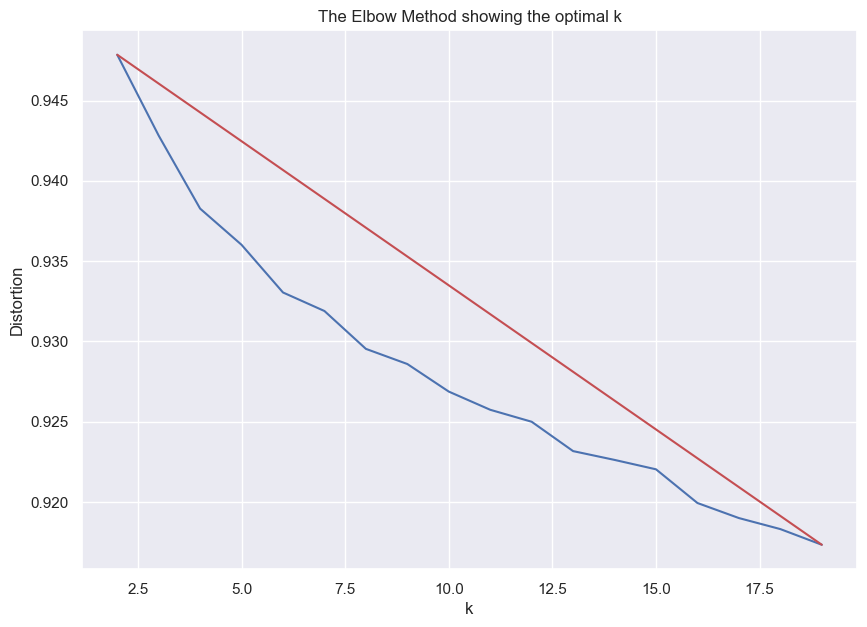

In [86]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [55]:
k = 13
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
clean_df['y'] = y_pred

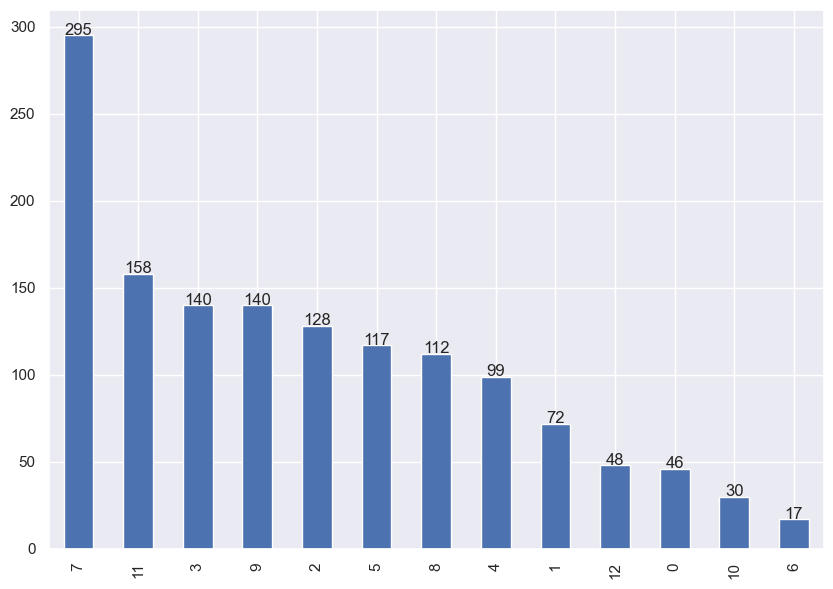

In [92]:
value_counts = clean_df['y'].value_counts()
ax = value_counts.plot.bar()
for i, v in enumerate(value_counts):
    ax.text(i, v + 0.5, str(v), ha='center')
plt.show()

In [97]:
for idx, text in enumerate(clean_df[clean_df["y"] == 0]["abstract"][:4].values):
    print("Index: ",idx)
    print(text)
    print("----------------------------------------------------------------")

Index:  0
Quantitative reverse transcription polymerase chain reaction (RT-qPCR) assay is the gold standard recommended to test for acute SARS-CoV-2 infection. [1] [2] [3] [4] It has been used by the Centers for Disease Control and Prevention (CDC) and several other companies in their Emergency Use Authorization (EUA) assays. With many PCR-based molecular assays, an extraction step is routinely used as part of the protocol. This step can take up a significant amount of time and labor, especially if the extraction is performed manually. Long assay time, partly caused by slow sample preparation steps, has created a large backlog when testing patient samples suspected of COVID-19. Using flu and RSV clinical specimens, we have collected evidence that the RT-qPCR assay can be performed directly on patient sample material from a nasal swab immersed in virus transport medium (VTM) without an RNA extraction step. We have also used this approach to test for the direct detection of SARS-CoV-2 re

In [56]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=50) 
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1402 samples in 0.010s...
[t-SNE] Computed neighbors for 1402 samples in 0.476s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1402
[t-SNE] Computed conditional probabilities for sample 1402 / 1402
[t-SNE] Mean sigma: 0.456139
[t-SNE] KL divergence after 250 iterations with early exaggeration: 121.633728
[t-SNE] KL divergence after 1000 iterations: 2.478245


In [69]:
X_emb = pd.DataFrame(X_embedded)
X_emb['pred'] = y_pred
X_emb

,0,1,pred
0,-2.118042,2.259120,7
1,-1.315420,-0.173601,3
2,-1.271666,0.799684,7
3,-4.343442,0.016968,7
4,-3.161078,-3.145598,8
...,...,...,...
1397,-2.958626,0.637496,7
1398,-2.207306,2.769697,7
1399,0.774370,0.680949,11
1400,-0.182341,2.059279,9


In [67]:
import seaborn as sns

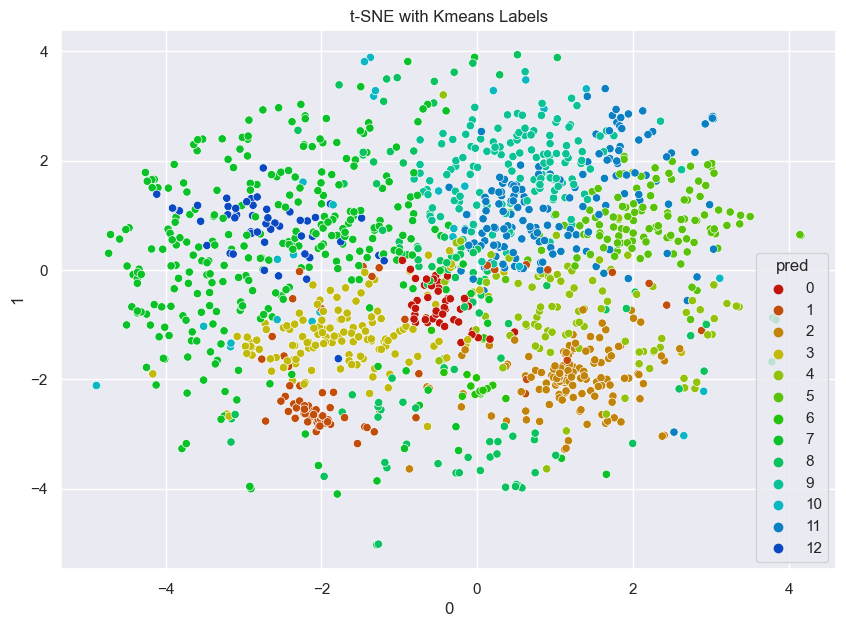

In [79]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(10,7)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(X_emb, x = 0, y = 1, hue='pred', legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.show()

In [57]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [58]:
vectorizers = []
    
for ii in range(0, 13):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [59]:
vectorizers[0]

CountVectorizer(max_df=0.9, min_df=5, stop_words='english',
                token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}')

In [60]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(clean_df.loc[clean_df['y'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [61]:
len(vectorized_data)

13

In [62]:
NUM_TOPICS_PER_CLUSTER = 13

lda_models = []

for ii in range(0, 13):
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(learning_method='online', n_components=13,
                          random_state=42, verbose=False)

In [63]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4
Current Cluster: 5
Current Cluster: 6
Current Cluster: 7
Current Cluster: 8
Current Cluster: 9
Current Cluster: 10
Current Cluster: 11
Current Cluster: 12


In [64]:
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names_out()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [65]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4
Current Cluster: 5
Current Cluster: 6
Current Cluster: 7
Current Cluster: 8
Current Cluster: 9
Current Cluster: 10
Current Cluster: 11
Current Cluster: 12


In [110]:
print(all_keywords[0][:20], end = '')

['qpcr', 'extraction', 'false', 'positive', 'sars', 'pcr', 'assay', 'cov-', 'rna', 'assays', 'time', 'samples', 'kits', 'detection', 'tests', 'testing', 'specimens', 'covid-', 'pandemic', 'cost']

In [111]:
af = clean_df.groupby('y')['affiliations'].aggregate(list)
af[8][0]

'Nishi Kumari (Panjab University, Chandigarh, India), Ayush Upadhyay (Delhi University, New Delhi, India), Kishan Kalia (D.A.V. College, Sector-10, Chandigarh, India), Rakesh Kumar (CSIR-Institute of Microbial Technology, Chandigarh, India), Kanika Tuteja (Panjab University, Chandigarh, India), Rani Paul (University of Lucknow, Lucknow, India), Eugenia Covernton (Paris, France), Tina Sharma (CSIR-Institute of Microbial Technology, Chandigarh, India), Vinod Scaria, Anshu Bhardwaj (CSIR-Institute of Microbial Technology, Chandigarh, India)'